In [1]:
import sys
sys.path.append("/Users/SamuelLP/Desktop/git/Challenge_Nexialog/script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

In [2]:
train = pd.read_csv("/Users/SamuelLP/Desktop/git/Challenge_Nexialog/data/application_train_vf.csv")
dataprep = DataPreparation(train, 0.3)
train_prepared, test_prepared = dataprep.get_prepared_data()

Type des variables convertis ✅


/Users/SamuelLP/Desktop/git/Challenge_Nexialog/script/data_preparation.py:155: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.train[var].fillna(0, inplace=True)
/Users/SamuelLP/Desktop/git/Challenge_Nexialog/script/data_preparation.py:158: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

Valeurs manquantes traitées ✅
Discrétisation des variables numériques en cours ... 


100%|██████████| 19/19 [04:50<00:00, 15.30s/it]


Variables numériques discrétisées ✅
Discrétisation des variables catégorielles en cours ... 


/Users/SamuelLP/Desktop/git/Challenge_Nexialog/script/data_preparation.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.train['CODE_GENDER'].replace('XNA', mode_gender, inplace=True)


Variables catégorielles discrétisées ✅


In [3]:
train_prepared.to_csv("/Users/SamuelLP/Desktop/git/Challenge_Nexialog/data/train_preparedV2.csv")
test_prepared.to_csv("/Users/SamuelLP/Desktop/git/Challenge_Nexialog/data/test_preparedV2.csv")

## Modélisation

In [4]:
features = ['AMT_CREDIT_SUM_DEBT_disc_int', 'AMT_CREDIT_SUM_disc_int', 'EXT_SOURCE_2_disc_int',  'EXT_SOURCE_1_disc_int', 'EXT_SOURCE_3_disc_int', 'DAYS_EMPLOYED_disc_int']
train_prepared[features]

,AMT_CREDIT_SUM_DEBT_disc_int,AMT_CREDIT_SUM_disc_int,EXT_SOURCE_2_disc_int,EXT_SOURCE_1_disc_int,EXT_SOURCE_3_disc_int,DAYS_EMPLOYED_disc_int
0,[32168.25;43650000.0],[0.0;632934.0],[0.47;0.85],[0.4;0.96],[0.33;0.9],[-2407;365243]
1,[-1083614.67;32167.93],[0.0;632934.0],[0.47;0.85],[0.4;0.96],[0.33;0.9],[-17912;-2408]
2,[32168.25;43650000.0],[632936.25;198072344.25],[0.47;0.85],[0.12;0.4],[0.33;0.9],[-2407;365243]
3,[-1083614.67;32167.93],[0.0;632934.0],[0.47;0.85],[0.12;0.4],[0.33;0.9],[-2407;365243]
4,[-1083614.67;32167.93],[0.0;632934.0],[0.0;0.15],[0.0;0.12],[0.33;0.9],[-2407;365243]
...,...,...,...,...,...,...
279995,[-1083614.67;32167.93],[0.0;632934.0],[0.47;0.85],[0.4;0.96],[0.33;0.9],[-2407;365243]
279996,[32168.25;43650000.0],[0.0;632934.0],[0.47;0.85],[0.4;0.96],[0.0;0.33],[-2407;365243]
279997,[32168.25;43650000.0],[0.0;632934.0],[0.47;0.85],[0.4;0.96],[0.33;0.9],[-2407;365243]
279998,[32168.25;43650000.0],[0.0;632934.0],[0.15;0.47],[0.12;0.4],[0.0;0.33],[-2407;365243]


In [14]:
reference_categories = {
    'AMT_CREDIT_SUM_DEBT_disc_int' : "[-1083614.67;32167.93]",
    'AMT_CREDIT_SUM_disc_int' : "[632936.25;198072344.25]", 
    'EXT_SOURCE_2_disc_int' : "[0.47;0.85]",  
    'EXT_SOURCE_1_disc_int' : "[0.4;0.96]", 
    'EXT_SOURCE_3_disc_int' : "[0.33;0.9]", 
    'DAYS_EMPLOYED_disc_int' : "[-17912;-2408]"}

In [15]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [16]:
model = Logit.from_formula(formula=formula, data=train_prepared)
logit_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.249169
         Iterations 7


# Modélisation

In [5]:
features = list(df_train.iloc[:,-7:].columns)
reference_categories = {var : df_train[var].mode()[0] for var in features}
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

model = Logit.from_formula(formula=formula, data=df_train)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2640676817106269
            Iterations: 51
            Function evaluations: 51
            Gradient evaluations: 51


## Prédictions

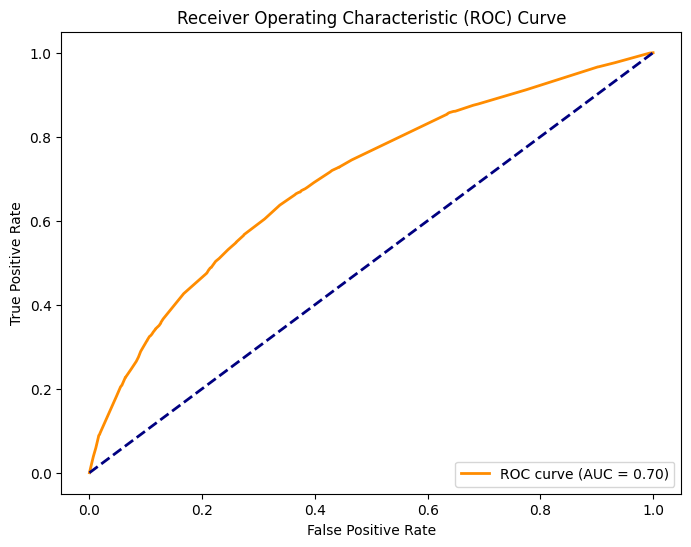

0.3946427777696806

In [17]:
pred = logit_model.predict(test_prepared)
fpr, tpr, thresholds = roc_curve(test_prepared["TARGET"],pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

In [18]:
confusion_matrix(test_prepared["TARGET"], np.round(pred))


array([[23788,     0],
       [ 2319,     0]])

In [8]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

nan

## Grille de score

In [19]:
GS = GridScore(train_prepared, logit_model)
grid_score = GS.compute_grid_score()

In [20]:
grid_score

,Variable,Modality,Coefficient,P-Value,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-3.796052,0.0,0.000000,0.0,0.00,0.00
1,AMT_CREDIT_SUM_DEBT_disc_int,[-1083614.67;32167.93]_ref,0.000000,0.0,105.263158,11.0,2.12,37.39
2,AMT_CREDIT_SUM_DEBT_disc_int,[32168.25;43650000.0],0.340000,0.0,0.000000,11.0,5.44,62.61
3,AMT_CREDIT_SUM_disc_int,[632936.25;198072344.25]_ref,0.000000,0.0,74.303406,8.0,0.66,11.58
4,AMT_CREDIT_SUM_disc_int,[0.0;632934.0],0.240000,0.0,0.000000,8.0,6.90,88.42
5,EXT_SOURCE_2_disc_int,[0.47;0.85]_ref,0.000000,0.0,201.238390,19.0,3.51,66.99
6,EXT_SOURCE_2_disc_int,[0.0;0.15],0.650000,0.0,0.000000,19.0,1.17,5.82
7,EXT_SOURCE_2_disc_int,[0.15;0.47],0.350000,0.0,92.879257,19.0,2.88,27.20
8,EXT_SOURCE_1_disc_int,[0.4;0.96]_ref,0.000000,0.0,272.445820,25.0,3.60,68.88
9,EXT_SOURCE_1_disc_int,[0.0;0.12],0.880000,0.0,0.000000,25.0,0.88,3.93


## Calcul des scores individuels


(array([ 3466.,  2645., 13064., 14696., 29502., 34863., 25835., 60650.,
        74857., 20422.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

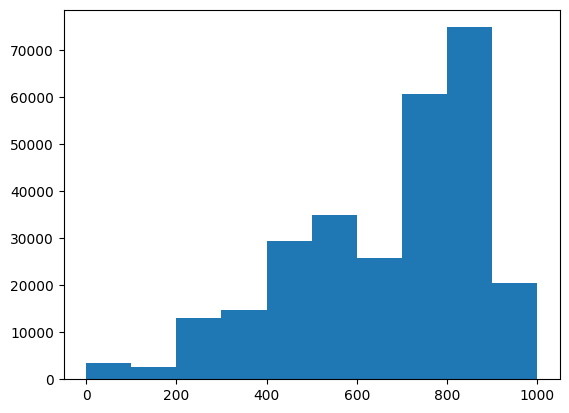

In [21]:
df_score = GS.get_individual_score()
plt.hist(df_score["Score_ind"])


In [22]:
df_score.to_csv("/Users/SamuelLP/Desktop/git/Challenge_Nexialog/data/df_score.csv")
